In [5]:
# Step 1: Import basic libraries
import pandas as pd
import numpy as np

print("Notebook is ready and basic libraries are loaded")


Notebook is ready and basic libraries are loaded


In [6]:
# Step 2: Load the dataset

fake_df = pd.read_csv(r"C:\Users\bvdas\Desktop\CODING\fake_news_detector\data\Fake.csv")
real_df = pd.read_csv(r"C:\Users\bvdas\Desktop\CODING\fake_news_detector\data\True.csv")

print("Fake news samples:", len(fake_df))
print("Real news samples:", len(real_df))

Fake news samples: 23481
Real news samples: 21417


In [7]:
# Step 3: Add labels and combine both datasets

# Labeling
fake_df['label'] = 0  # Fake = 0
real_df['label'] = 1  # Real = 1

# Combine both datasets
data = pd.concat([fake_df, real_df], ignore_index=True)

# Shuffle the data so fake and real are mixed
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Quick look
print("Combined dataset shape:", data.shape)
print("First few rows:")
data[['title', 'label']].head()

Combined dataset shape: (44898, 5)
First few rows:


,title,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,0
1,Trump drops Steve Bannon from National Securit...,1
2,Puerto Rico expects U.S. to lift Jones Act shi...,1
3,OOPS: Trump Just Accidentally Confirmed He Le...,0
4,Donald Trump heads for Scotland to reopen a go...,1


In [11]:
# Step 4: Clean the text column

import re
import string
import nltk
from nltk.corpus import stopwords

# Download stopwords (only once)
nltk.download('stopwords')

# Function to clean each news article
def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'\[.*?\]', '', text)  # remove [text]
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # remove URLs
    text = re.sub(r'<.*?>+', '', text)  # remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # remove punctuation
    text = re.sub(r'\n', ' ', text)  # remove line breaks
    text = re.sub(r'\w*\d\w*', '', text)  # remove words with numbers
    # remove stopwords
    text = ' '.join(word for word in text.split() if word not in stopwords.words('english'))
    return text

# Apply to the "text" column (news body)
data['clean_text'] = data['text'].apply(clean_text)

# Show a sample cleaned news article
print("🧹 Cleaned sample:\n")
print(data['clean_text'][0][:500])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bvdas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


🧹 Cleaned sample:

well take long short time since americans kindasorta elected donald trump pussygrabberinchief trump appointed bona fide white nationalist highlevel position perform numerous actions months ago considered extremely unlikely nightmare scenarios latest seems muslim registry media told us trump serious might actually happenunder trump regime muslim immigrants coming united states trump pals call terrorprone countries soon register check regularly government trump adviser kansas secretary state kris 


In [12]:
# Save the cleaned dataset to avoid repeating this long step
data.to_csv("cleaned_news_data.csv", index=False)
print("Cleaned dataset saved as 'cleaned_news_data.csv'")

Cleaned dataset saved as 'cleaned_news_data.csv'


In [14]:
# ✅ Step 5: Convert text to vectors using TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

# Create the TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # limit to top 5000 words for performance

# Fit and transform the 'clean_text' column
X = tfidf.fit_transform(data['clean_text'])

# Output the shape of the TF-IDF matrix
print(" TF-IDF shape:", X.shape)

 TF-IDF shape: (2000, 5000)


In [15]:
from sklearn.model_selection import train_test_split

# Step 6.1: Labels (target output)
y = data['label']  # 0 = fake, 1 = real

# Step 6.2: Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Print the shapes of the splits
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (1600, 5000)
Test shape: (400, 5000)


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Step 7.1: Create the model
model = LogisticRegression(max_iter=1000)  # Increase max_iter to ensure convergence

# Step 7.2: Train it on the training data
model.fit(X_train, y_train)

# Step 7.3: Predict on the test set
y_pred = model.predict(X_test)

# Step 7.4: Evaluate the model
print(" Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

 Accuracy: 0.96

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96       211
           1       0.95      0.96      0.96       189

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400



In [17]:
import joblib

# Step 8.1: Save the trained model
joblib.dump(model, "fake_news_model.pkl")
print(" Model saved as fake_news_model.pkl")

# Step 8.2: Save the TF-IDF vectorizer too
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
print("TF-IDF vectorizer saved as tfidf_vectorizer.pkl")

# Step 8.3: Try a custom prediction
def predict_news(text):
    # Clean the text like before
    cleaned = clean_text(text)
    # Convert to TF-IDF
    vector = tfidf.transform([cleaned])
    # Predict
    prediction = model.predict(vector)
    return " Real News" if prediction[0] == 1 else "🚨 Fake News"

# Example usage
sample_news = "The prime minister has announced a new economic policy today."
print("\nPrediction for sample news:")
print(predict_news(sample_news))

 Model saved as fake_news_model.pkl
TF-IDF vectorizer saved as tfidf_vectorizer.pkl

Prediction for sample news:
 Real News


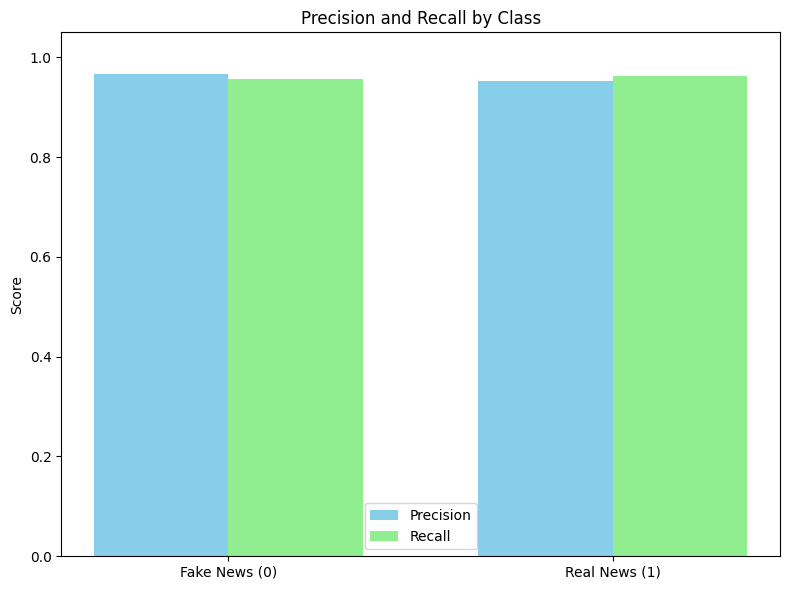

In [21]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# y_test: true labels | y_pred: predicted labels
report = classification_report(y_test, y_pred, output_dict=True)

# Extract precision and recall for each class (0 = Fake, 1 = Real)
classes = ['Fake News (0)', 'Real News (1)']
precision = [report['0']['precision'], report['1']['precision']]
recall = [report['0']['recall'], report['1']['recall']]

# Plot
x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, precision, width, label='Precision', color='skyblue')
plt.bar(x + width/2, recall, width, label='Recall', color='lightgreen')

plt.ylabel('Score')
plt.title('Precision and Recall by Class')
plt.xticks(x, classes)
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()

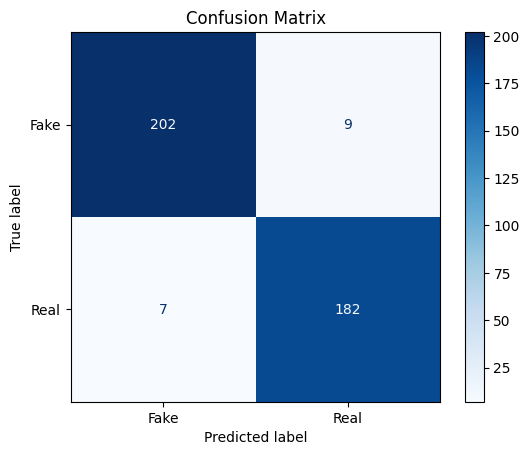

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Load saved model and vectorizer
import joblib
model = joblib.load(r"C:\Users\bvdas\Desktop\CODING\fake_news_detector\notebooks\fake_news_model.pkl")
vectorizer = joblib.load(r"C:\Users\bvdas\Desktop\CODING\fake_news_detector\notebooks\tfidf_vectorizer.pkl")

# Example news articles for prediction:
new_articles = [
    "Government launches new health care scheme to help underprivileged.",
    "Breaking: Celebrity found to be a reptilian alien in disguise!",
    "NASA confirms presence of water on the Moon.",
]

# Preprocess same as training 
X_new = vectorizer.transform(new_articles)
predictions = model.predict(X_new)

# Display results
for i, text in enumerate(new_articles):
    label = "Real" if predictions[i] == 1 else "Fake"
    print(f"News: {text}\nPrediction: {label}\n{'-'*60}")

News: Government launches new health care scheme to help underprivileged.
Prediction: Fake
------------------------------------------------------------
News: Breaking: Celebrity found to be a reptilian alien in disguise!
Prediction: Fake
------------------------------------------------------------
News: NASA confirms presence of water on the Moon.
Prediction: Fake
------------------------------------------------------------
